In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Reloading the module
import importlib

import OrthogonalPolynomials
importlib.reload(OrthogonalPolynomials)
from OrthogonalPolynomials import *

import GeneralFunctionality
importlib.reload(GeneralFunctionality)
from GeneralFunctionality import *

from scipy.special import eval_legendre, roots_legendre
from scipy import integrate

In [2]:
# Finding the Legendre Gauss points
N = 40
# Node index: 0,1,...,N -> N+1 nodes -> zeros of L_{N+1}
x_Le, w_Le = roots_legendre(N+1)
# Barycentric weights
w_bary = BarycentricWeights(x_Le)
# Differentiation matrix
D = PolynomialDiffMatrix(x_Le, w_bary)

In [3]:
def MatrixG(N, D, w): 
    # Computing the matrix G on the RHS of the ODE system
    # G corresponds to -\hat{D} in the book
    # D: differentiation matrix
    # w: Legendre Gauss weights
    # The subroutine can be improved by numpy vectorization
    
    G = np.zeros((N+1, N+1))
    for j in range(N+1):
        for n in range(N+1):
            G[j,n] = D[n,j] * w[n] / w[j]
            
    return G

G = MatrixG(N, D, w_Le)

In [4]:
def LagrangePolynomialsBoundaryValues(N, x_nodes, w_bary):
    # Computing l_j(-1), l_j(1) for j=0,1,...,N
    # x_nodes: interpolating nodes
    # w_bary: barycentric weights
    
    l_left = np.zeros(N+1)
    l_right = np.zeros(N+1)
    
    for j in range(N+1):
        l_left[j] = LagrangePolynomialBary(j, -1.0, x_nodes, w_bary)
        l_right[j] = LagrangePolynomialBary(j, 1.0, x_nodes, w_bary)
    
    return l_left, l_right

l_left, l_right = LagrangePolynomialsBoundaryValues(N, x_Le, w_bary)

In [5]:
def BC_left(t):
    # The boundary condition on the left
    return 0

def RHS(t, u, N, x_Le, w_Le, w_bary, G, l_left, l_right, BC_left):
    # Evaluating the RHS of the ODE system
    
    # The value of the interpolating polynomial at x=1
    u_right = LagrangeInterpolationBary(1, x_Le, u, w_bary)
    
    # The left boundary value
    # 'g' is used to be consistent with the notation in the book
    g = BC_left(t)
    
    rhs = (g*l_left - u_right*l_right) / w_Le + np.dot(G, u)
    
    return rhs

Text(0.5, 1.0, '$u_t+u_{x}=0$')

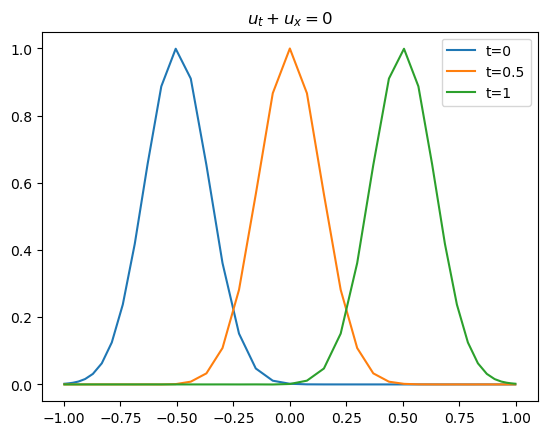

In [6]:
# Scipy calculation

# Initial condition
u0 = np.exp(-(x_Le+0.5)**2/0.04)

t_span = [0, 1]
t_eval=[0, 0.5, 1]
sol = solve_ivp(RHS, 
                t_span=t_span, 
                y0=u0, 
                method='RK45', 
                t_eval=t_eval, 
                args=(N, x_Le, w_Le, w_bary, G, l_left, l_right, BC_left))

fig = plt.figure()
ax = fig.add_subplot(111)

Nt = len(t_eval)
for it in range(Nt):
    ax.plot(x_Le, sol.y[:,it], label='t={}'.format(t_eval[it]))

ax.legend()
ax.set_title(r'$u_t+u_{x}=0$')

Text(0.5, 1.0, '$u_t+u_{x}=0$')

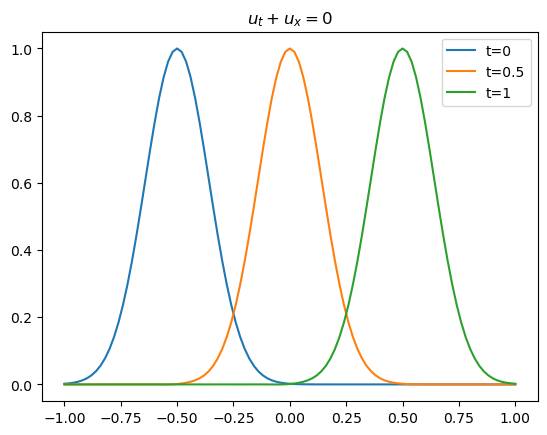

In [7]:
# Interpolating to a finer grid for plotting purpose
y = np.linspace(-1,1,101)
T = InterpolatingMatrix(x_Le, y, w_bary)

fig = plt.figure()
ax = fig.add_subplot(111)

Nt = len(t_eval)
for it in range(Nt):
    u = sol.y[:,it]
    u_newgrid = np.dot(T, u)
    ax.plot(y, u_newgrid, label='t={}'.format(t_eval[it]))


ax.legend()
ax.set_title(r'$u_t+u_{x}=0$')


## Propogation in the opposite direction

In [8]:
def BC_right(t):
    # The boundary condition on the left
    # return np.sin(3*t)**2
    # return 0
    return np.sin(3*t)

def RHS_opposite(t, u, N, x_Le, w_Le, w_bary, G, l_left, l_right, BC_right):
    # Evaluating the RHS of the ODE system
    # The advection is in the negative x direction
    
    # The value of the interpolating polynomial at x=-1
    u_left = LagrangeInterpolationBary(-1.0, x_Le, u, w_bary)
    
    # The right boundary value
    # 'g' is used to be consistent with the notation in the book
    g = BC_right(t)
    
    rhs = (g*l_right - u_left*l_left) / w_Le - np.dot(G, u)
    
    return rhs

Text(0.5, 1.0, '$u_t-u_{x}=0$')

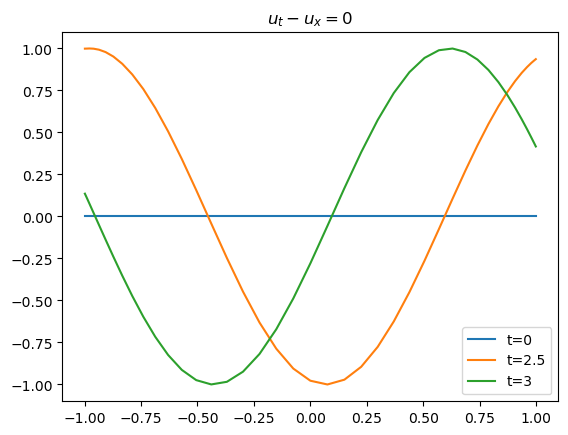

In [9]:
# Scipy calculation

# Initial condition

u0 = np.exp(-(x_Le-0.5)**2/0.04)
u0 = np.zeros(N+1)

t_span = [0, 5]
t_eval=[0, 2.5, 3]
sol = solve_ivp(RHS_opposite, 
                t_span=t_span, 
                y0=u0, 
                method='RK45', 
                t_eval=t_eval, 
                args=(N, x_Le, w_Le, w_bary, G, l_left, l_right, BC_right))

fig = plt.figure()
ax = fig.add_subplot(111)

Nt = len(t_eval)
for it in range(Nt):
    ax.plot(x_Le, sol.y[:,it], label='t={}'.format(t_eval[it]))

ax.legend()
ax.set_title(r'$u_t-u_{x}=0$')

Text(0.5, 1.0, '$u_t-u_{x}=0$')

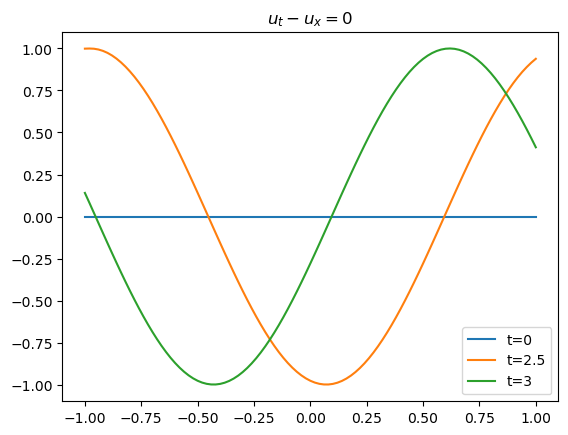

In [10]:
# Interpolating to a finer grid for plotting purpose
y = np.linspace(-1,1,101)
T = InterpolatingMatrix(x_Le, y, w_bary)

fig = plt.figure()
ax = fig.add_subplot(111)

Nt = len(t_eval)
for it in range(Nt):
    u = sol.y[:,it]
    u_newgrid = np.dot(T, u)
    ax.plot(y, u_newgrid, label='t={}'.format(t_eval[it]))


ax.legend()
ax.set_title(r'$u_t-u_{x}=0$')
